# Examine Eli's SCHA processed tidal signal, decide on a high pass filter based on how well it correlates with the Jersey Point salinity signal 

In [1]:
#import xarray as xr

import numpy as np
import pandas as pd
# from pathlib import Path

# import os, sys
# import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as tkr
#import seaborn as sns
#sns.set_style('ticks')
from scipy import signal
# from scipy import stats
# from scipy.stats import percentileofscore

from datetime import datetime, timedelta
from vtools.functions.filter import cosine_lanczos
from vtools.data.vtime import days, hours, minutes


/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#which version of scipy signal do I have?
import scipy
print(scipy.__version__)

1.7.3


In [3]:
#function comes from schimpy metricsplot.py script https://github.com/CADWRDeltaModeling/schimpy/blob/master/schimpy/metricsplot.py
def filter_timeseries(tss, cutoff_period=hours(40)):
    """ Filter time series

        Parameters
        ----------

        Returns
        -------
        list of vtools.data.timeseries.TimeSeries
            filtered time series
    """

    filtered = []
    ts=tss #try removing the loop for now
    if ts is None:
        filtered.append(None)
    else:
        #print(ts)
        ts_filtered = cosine_lanczos(ts, cutoff_period=cutoff_period)
        ts_filtered.filtered = 'cosine_lanczos'
        #ts_filtered.unit = ts.unit
        #filtered.append(ts_filtered)
    # for ts in tss:
    #     if ts is None:
    #         filtered.append(None)
    #     else:
    #         print(ts)
    #         ts_filtered = cosine_lanczos(ts, cutoff_period=cutoff_period)
    #         ts_filtered.filtered = 'cosine_lanczos'
    #         ts_filtered.unit = ts.unit
    #         filtered.append(ts_filtered)
    return ts_filtered

In [4]:
#Load the SCHA filtered tidal signals
headers=['datetime','subtide','filled']
dtformat = '%Y-%m-%dT%H:%M:%S'
ptreyes=pd.read_csv("/global/scratch/users/jennaisrael/time_varying_data/tide_gauge_data/SCHA_ptreyes.csv",header=0,names=headers)
ptreyes['datetime']=pd.to_datetime(ptreyes['datetime'],format=dtformat)
ptreyes.set_index("datetime",inplace=True)
ptreyes=ptreyes.asfreq('30min')

monterey=pd.read_csv("/global/scratch/users/jennaisrael/time_varying_data/tide_gauge_data/SCHA_monterey.csv",header=0,names=headers)
monterey['datetime']=pd.to_datetime(monterey['datetime'],format=dtformat)
monterey.set_index("datetime",inplace=True)
monterey=monterey.asfreq('30min')
monterey

,subtide,filled
datetime,,
2012-01-01 00:00:00,NaN,NaN
2012-01-01 00:30:00,NaN,NaN
2012-01-01 01:00:00,NaN,NaN
2012-01-01 01:30:00,NaN,NaN
2012-01-01 02:00:00,NaN,NaN
...,...,...
2023-12-31 22:00:00,NaN,NaN
2023-12-31 22:30:00,NaN,NaN
2023-12-31 23:00:00,NaN,NaN


In [5]:
#Load the salinity data and filter it

dtformat = '%Y-%m-%dT%H:%M:%S'

jer_dms=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/dms_data_jer.csv")
jer_dms=jer_dms.rename(columns={"screened/jer//usbr/JER/ec/microS/cm": "jer_S[mS/cm]"})
jer_dms['datetime']=pd.to_datetime(jer_dms['datetime'],format=dtformat)
# jer_dms.set_index("datetime",inplace=True)
# jer_dms=jer_dms.asfreq('15min')
#jer_dms_filt=filter_timeseries(jer_dms)

sjj_dms=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/dms_data_sjj.csv")
sjj_dms=sjj_dms.rename(columns={"screened/sjj//usgs/11337190/ec/microS/cm": "sjj_S[mS/cm]"})
sjj_dms['datetime']=pd.to_datetime(sjj_dms['datetime'],format=dtformat)
# sjj_dms.set_index("datetime",inplace=True)
# sjj_dms=sjj_dms.asfreq('15min')
#sjj_dms_filt=filter_timeseries(sjj_dms)

# hol2_dms=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/dms_data_hol2.csv")
# hol2_dms=hol2_dms.rename(columns={"screened/hol2//dwr_ncro/B95120/ec/microS/cm": "hol2_S[mS/cm]"})
# hol2_dms['datetime']=pd.to_datetime(hol2_dms['datetime'],format=dtformat)
# hol2_dms.set_index("datetime",inplace=True)
# hol2_dms=hol2_dms.asfreq('15min')
# hol2_dms_filt=filter_timeseries(hol2_dms)

In [6]:
# Use the USGS sjj station to gapfill the USBR jer station
jp=jer_dms.combine_first(sjj_dms) #see documentation for this pandas built in https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.combine_first.html

In [7]:
jp

,datetime,jer_S[mS/cm],sjj_S[mS/cm]
0,2009-08-29 15:15:00,1489.0,3680.0
1,2009-08-29 15:30:00,1487.0,3860.0
2,2009-08-29 15:45:00,1448.0,4120.0
3,2009-08-29 16:00:00,1436.0,4410.0
4,2009-08-29 16:15:00,1426.0,4500.0
...,...,...,...
561915,2025-09-07 22:00:00,1275.0,NaN
561916,2025-09-07 22:15:00,1278.0,NaN
561917,2025-09-07 22:30:00,1277.0,NaN
561918,2025-09-07 22:45:00,1279.0,NaN


In [8]:
# Are there gaps longer than 1 day?
# singleseries = df[df.group == 'A']
# singleseries['gap'] = singleseries['date'].sort_values().diff() > pd.to_timedelta('1 day')
# singleseries[singleseries.gap]
jp_single = jp.drop(columns=['sjj_S[mS/cm]']).dropna(axis='rows')
jp_single['gap_length']= jp_single['datetime'].sort_values().diff()
jp_single['gap'] = jp_single['gap_length'] > pd.to_timedelta('1 day')
jp_single[jp_single.gap]

,datetime,jer_S[mS/cm],gap_length,gap
19176,2010-03-17 09:15:00,265.0,1 days 21:15:00,True
352677,2019-09-20 08:30:00,190.0,1 days 06:15:00,True
457809,2022-09-19 11:30:00,1334.0,2 days 23:30:00,True
463291,2022-11-15 14:00:00,1774.0,4 days 08:15:00,True
464737,2022-11-30 15:30:00,2560.0,15 days 01:15:00,True
546500,2025-03-31 08:15:00,162.0,2 days 19:30:00,True
547085,2025-04-06 10:30:00,157.0,2 days 05:30:00,True
547209,2025-04-07 17:30:00,192.0,1 days 04:30:00,True
547857,2025-04-14 11:30:00,144.0,2 days 08:00:00,True
551854,2025-05-26 02:45:00,188.0,17 days 17:45:00,True


In [9]:
#fill gaps 

In [10]:
#filter gap filled salinity signal

# Try high pass filtering the SCHA filtered signal to remove the seasonal signal

In [11]:
#first drop the na
ptreyes=ptreyes.dropna(axis='rows')
monterey=monterey.dropna(axis='rows')

In [12]:
ptreyes

,subtide,filled
datetime,,
2012-01-03 01:30:00,0.9306,0.9750
2012-01-03 02:00:00,0.9299,1.0670
2012-01-03 02:30:00,0.9292,1.1670
2012-01-03 03:00:00,0.9285,1.2700
2012-01-03 03:30:00,0.9279,1.3700
...,...,...
2023-12-29 20:30:00,1.2244,0.2927
2023-12-29 21:00:00,1.2226,0.4265
2023-12-29 21:30:00,1.2207,0.5852


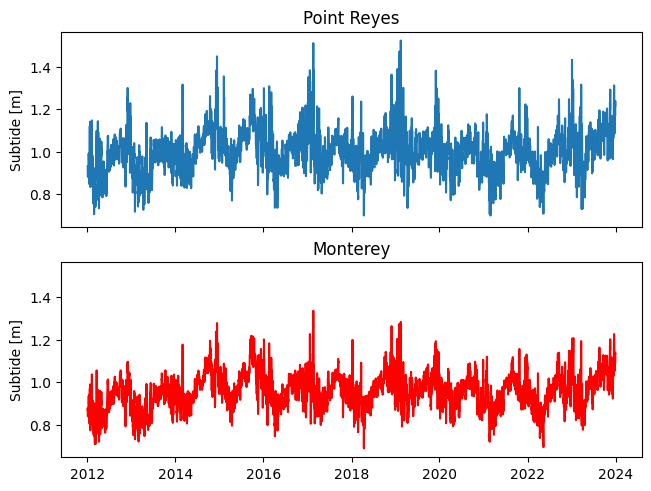

In [13]:
#plot the signals
fig, ax = plt.subplots(2,1,layout='constrained',sharex=True, sharey=True)

ax[0].plot(ptreyes.subtide,label='Pt Reyes')
ax[1].plot(monterey.subtide,label='Monterey',color='r')
ax[0].set_ylabel('Subtide [m]')
ax[1].set_ylabel('Subtide [m]')
ax[0].set_title('Point Reyes')
ax[1].set_title('Monterey')
#fig.legend()
plt.show()

In [14]:
#try a 3 month high pass filter
#try a 6th order elliptical filter as is used in Bromirski et al.
#30 minute sampling frequency to Hertz
fstide=1/(30*60)
rp=5
rs=50
fcutoff_3m=1/(60*60*24*30*3)
sos_3m = signal.ellip(6, rp, rs, fcutoff_3m, 'highpass', fs=fstide, output='sos')
fcutoff_30d=1/(60*60*24*30)
sos_30d = signal.ellip(6, rp, rs, fcutoff_30d, 'highpass', fs=fstide, output='sos')
fcutoff_180d=1/(60*60*24*180)
sos_180d = signal.ellip(6, rp, rs, fcutoff_180d, 'highpass', fs=fstide, output='sos')
fcutoff_365d=1/(60*60*24*365)
sos_365d = signal.ellip(6, rp, rs, fcutoff_365d, 'highpass', fs=fstide, output='sos')

ptreyes['ellip_3m_filt'] = signal.sosfilt(sos_3m, ptreyes.subtide)
ptreyes['ellip_30d_filt'] = signal.sosfilt(sos_30d, ptreyes.subtide)
ptreyes['ellip_180d_filt'] = signal.sosfilt(sos_180d, ptreyes.subtide)
ptreyes['ellip_365d_filt'] = signal.sosfilt(sos_365d, ptreyes.subtide)

monterey['ellip_3m_filt'] = signal.sosfilt(sos_3m, monterey.subtide)
monterey['ellip_30d_filt'] = signal.sosfilt(sos_30d, monterey.subtide)
monterey['ellip_180d_filt'] = signal.sosfilt(sos_180d, monterey.subtide)
monterey['ellip_365d_filt'] = signal.sosfilt(sos_365d, monterey.subtide)


/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

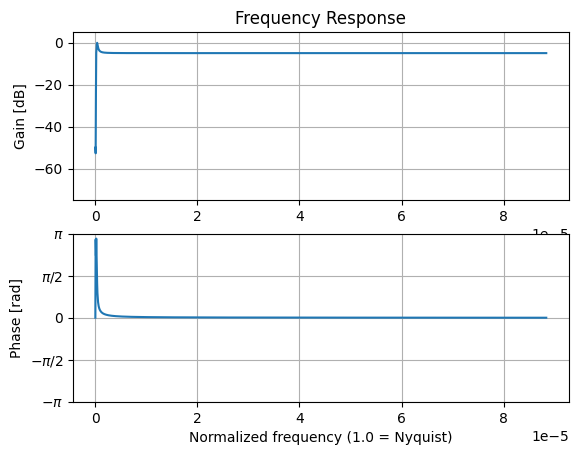

In [15]:
w, h = signal.sosfreqz(sos_30d, worN=1500,fs=fstide) #version 1.7 https://docs.scipy.org/doc//scipy-1.7.0/reference/generated/scipy.signal.sosfreqz.html

plt.subplot(2, 1, 1)
db = 20*np.log10(np.maximum(np.abs(h), 1e-5))
plt.plot(w/np.pi, db)
plt.ylim(-75, 5)
plt.grid(True)
plt.yticks([0, -20, -40, -60])
plt.ylabel('Gain [dB]')
plt.title('Frequency Response')
plt.subplot(2, 1, 2)
plt.plot(w/np.pi, np.angle(h))
plt.grid(True)
plt.yticks([-np.pi, -0.5*np.pi, 0, 0.5*np.pi, np.pi],
           [r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$'])
plt.ylabel('Phase [rad]')
plt.xlabel('Normalized frequency (1.0 = Nyquist)')
plt.show()

In [16]:
np.abs(h)

array([0.00316228, 0.00231604, 0.06872882, ..., 0.56234133, 0.56234133,
       0.56234133])

In [54]:
#try a boxcar to compare with the elliptical filter
#30 minute sampling frequency to Hertz
ptide=30 #data collection period in minutes
M_18d=int((60*24*18)/ptide) #size of the window in samples
box_18d = np.ones(M_18d)/M_18d
M_40d=int((60*24*40)/ptide) #size of the window in samples
box_40d = np.ones(M_40d)/M_40d

M_100d=int((60*24*100)/ptide)
box_100d = np.ones(M_100d)/M_100d
M_190d=int((60*24*190)/ptide)
box_190d = np.ones(M_190d)/M_190d

#to implement the box car, convolve with the window, then trim the errorneous values as the beginnibg and end when using this 'same' method
Npr=len(ptreyes.subtide)
Nmb=len(monterey.subtide)

ptreyes['box_18d_filt'] = ptreyes.subtide.sub(signal.convolve(ptreyes.subtide,box_18d,mode='same'))
#ptreyes['box_40d_filt'] =  ptreyes.subtide-signal.convolve(ptreyes.subtide,box_40d_sig)
ptreyes['box_40d_filt'] =  ptreyes.subtide-signal.convolve(ptreyes.subtide,box_40d,mode='same')
ptreyes['box_100d_filt'] = ptreyes.subtide-signal.convolve(ptreyes.subtide,box_100d,mode='same')
ptreyes['box_190d_filt'] = ptreyes.subtide-signal.convolve(ptreyes.subtide,box_190d,mode='same')


monterey['box_18d_filt'] = monterey.subtide-signal.convolve(monterey.subtide,box_18d,mode='same')
monterey['box_40d_filt'] =  monterey.subtide-signal.convolve(monterey.subtide,box_40d,mode='same')
monterey['box_100d_filt'] = monterey.subtide-signal.convolve(monterey.subtide,box_100d,mode='same')
monterey['box_190d_filt'] = monterey.subtide-signal.convolve(monterey.subtide,box_190d,mode='same')

#throw out the first and last M entries due to width of box car
ptreyes['box_18d_filt'][0:M_18d] = np.nan
ptreyes['box_18d_filt'][Npr-M_18d:] = np.nan
ptreyes['box_40d_filt'][0:M_40d] = np.nan
ptreyes['box_40d_filt'][Npr-M_40d:] = np.nan
ptreyes['box_100d_filt'][0:M_100d] = np.nan
ptreyes['box_100d_filt'][Npr-M_100d:] = np.nan
ptreyes['box_190d_filt'][0:M_190d] = np.nan
ptreyes['box_190d_filt'][Npr-M_190d:] = np.nan

monterey['box_18d_filt'][0:M_18d] = np.nan
monterey['box_18d_filt'][Nmb-M_18d:] = np.nan
monterey['box_40d_filt'][0:M_40d] = np.nan
monterey['box_40d_filt'][Nmb-M_40d:] = np.nan
monterey['box_100d_filt'][0:M_100d] = np.nan
monterey['box_100d_filt'][Nmb-M_100d:] = np.nan
monterey['box_190d_filt'][0:M_190d] = np.nan
monterey['box_190d_filt'][Nmb-M_190d:] = np.nan


/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [20]:
padl

208267

In [22]:
np.zeros(int(np.floor(padl/2)))

array([0., 0., 0., ..., 0., 0., 0.])

In [19]:
signal.convolve(ptreyes.subtide,box_18d)

array([0.00107708, 0.00215336, 0.00322882, ..., 0.0042316 , 0.00281875,
       0.00140822])

In [20]:
len(signal.convolve(ptreyes.subtide,box_18d,mode='same'))

210187

In [25]:
len(signal.convolve(ptreyes.subtide,box_40d_sig))

420373

In [31]:
M_40d

1920

In [38]:
M_40d/2

960.0

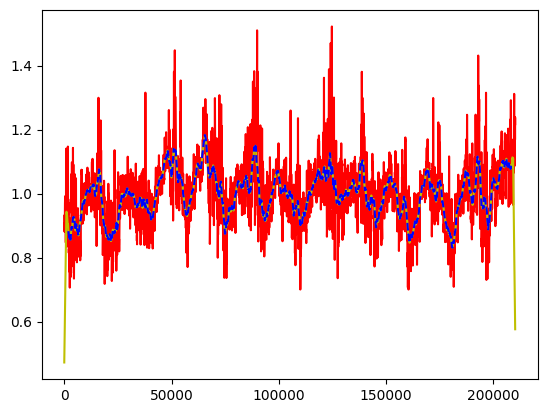

In [52]:
ftrim=int(np.floor(M_40d/2))
btrim=int(np.ceil(M_40d/2))
subtide_pad=np.concatenate([np.zeros(ftrim),ptreyes.subtide,np.zeros(btrim)])

fig, ax=plt.subplots(sharex=True)
ax.plot(np.arange(0,210187),ptreyes.subtide,color='r')
ax.plot(np.arange(0,210187),signal.convolve(ptreyes.subtide,box_40d,mode='same'),color='y')
ax.plot(np.arange(M_40d,(210187-M_40d)),signal.convolve(subtide_pad,box_40d)[2*M_40d:len(ptreyes.subtide)],color='b',linestyle='--')
#ax.set_xlim([0,10000])

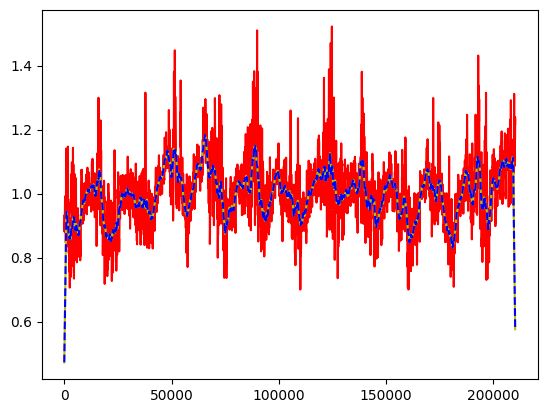

In [41]:
fig, ax=plt.subplots(sharex=True)

#plt.plot(signal.convolve(box_18d,ptreyes.subtide))
#ax2=ax.twinx()
ax.plot(np.arange(0,210187),ptreyes.subtide,color='r')
#ax.plot(np.arange(0,420373),signal.convolve(ptreyes.subtide,box_40d_sig))
ax.plot(np.arange(0,210187),signal.convolve(ptreyes.subtide,box_40d,mode='same'),color='y')
#try trimming just the middle
ftrim=int(M_40d/2)
#ax.plot(np.arange(0,210187),signal.convolve(ptreyes.subtide,box_40d)[ftrim:len(ptreyes.subtide)+ftrim],color='b', linestyle='--') #this works
ax.plot(np.arange(0,210187),signal.convolve(ptreyes.subtide,box_40d)[ftrim:len(ptreyes.subtide)+ftrim],color='b', linestyle='--')

#ax.set_xlim([0,10000])

In [37]:
len(signal.convolve(ptreyes.subtide,box_40d_sig)[])

210186

In [22]:
monterey

,subtide,filled,ellip_3m_filt,ellip_30d_filt,ellip_180d_filt,ellip_365d_filt,box_18d_filt,box_40d_filt,box_100d_filt,box_190d_filt
datetime,,,,,,,,,,
2012-01-03 01:30:00,0.8713,0.9420,0.489290,0.487929,0.489629,0.489801,0.431461,0.428814,0.437942,0.446792
2012-01-03 02:00:00,0.8715,1.0320,0.488045,0.483944,0.489064,0.489579,0.430579,0.428501,0.437984,0.446909
2012-01-03 02:30:00,0.8717,1.1300,0.486795,0.479923,0.488497,0.489358,0.429696,0.428188,0.438026,0.447024
2012-01-03 03:00:00,0.8720,1.2320,0.485598,0.475922,0.487986,0.489192,0.428914,0.427974,0.438167,0.447240
2012-01-03 03:30:00,0.8722,1.3310,0.484339,0.471830,0.487417,0.488969,0.428032,0.427659,0.438208,0.447356
...,...,...,...,...,...,...,...,...,...,...
2023-12-29 20:30:00,1.1369,0.3367,-0.050550,0.054561,0.026294,0.024913,0.574948,0.586469,0.601985,0.607064
2023-12-29 21:00:00,1.1363,0.4742,-0.050890,0.053636,0.025861,0.024522,0.575739,0.586350,0.601589,0.606572
2023-12-29 21:30:00,1.1357,0.6271,-0.051228,0.052714,0.025428,0.024132,0.576527,0.586232,0.601193,0.606080


In [23]:
monterey['ellip_3m_filt'].max()

0.48929021443587845

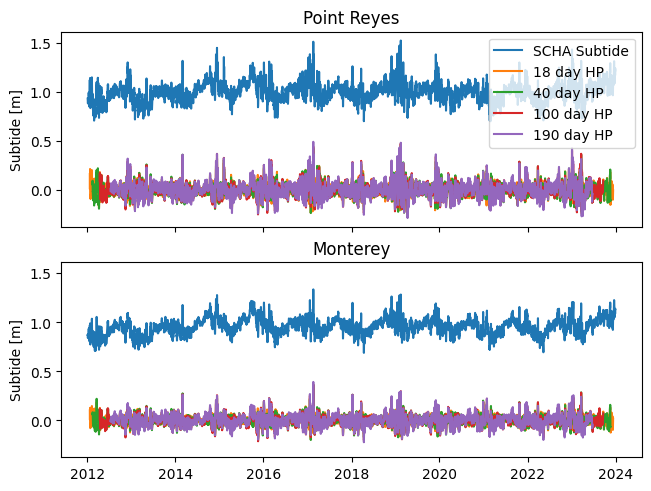

In [56]:
#plot the signals
fig, ax = plt.subplots(2,1,layout='constrained',sharex=True, sharey=True)

ax[0].plot(ptreyes.subtide,label='SCHA Subtide')
ax[0].plot(ptreyes['box_18d_filt'],label='18 day HP')
ax[0].plot(ptreyes['box_40d_filt'],label='40 day HP')
ax[0].plot(ptreyes['box_100d_filt'],label='100 day HP')
ax[0].plot(ptreyes['box_190d_filt'],label='190 day HP')

ax[1].plot(monterey.subtide,label='SCHA Subtide')
ax[1].plot(monterey['box_18d_filt'],label='18 day HP')
ax[1].plot(monterey['box_40d_filt'],label='40 day HP')
ax[1].plot(monterey['box_100d_filt'],label='100 day HP')
ax[1].plot(monterey['box_190d_filt'],label='190 day HP')

ax[0].set_ylabel('Subtide [m]')
ax[1].set_ylabel('Subtide [m]')
ax[0].set_title('Point Reyes')
ax[1].set_title('Monterey')
ax[0].legend()
plt.show()

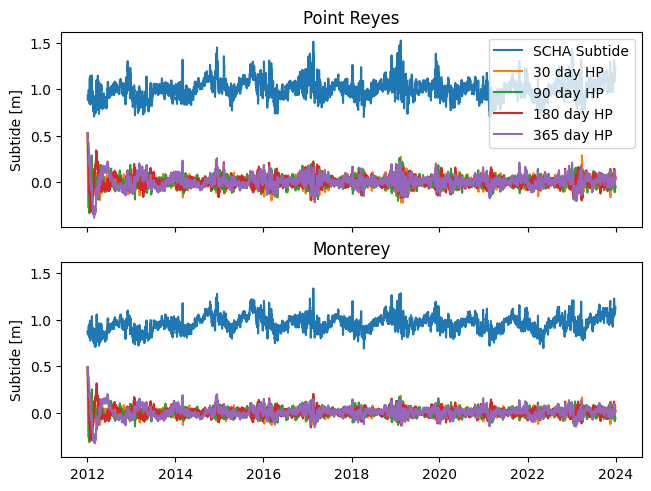

In [57]:
#plot the signals
fig, ax = plt.subplots(2,1,layout='constrained',sharex=True, sharey=True)

ax[0].plot(ptreyes.subtide,label='SCHA Subtide')
ax[0].plot(ptreyes['ellip_30d_filt'],label='30 day HP')
ax[0].plot(ptreyes['ellip_3m_filt'],label='90 day HP')
ax[0].plot(ptreyes['ellip_180d_filt'],label='180 day HP')
ax[0].plot(ptreyes['ellip_365d_filt'],label='365 day HP')

ax[1].plot(monterey.subtide,label='SCHA Subtide')
ax[1].plot(monterey['ellip_30d_filt'],label='30 day HP')
ax[1].plot(monterey['ellip_3m_filt'],label='90 day HP')
ax[1].plot(monterey['ellip_180d_filt'],label='180 day HP')
ax[1].plot(monterey['ellip_365d_filt'],label='365 day HP')

ax[0].set_ylabel('Subtide [m]')
ax[1].set_ylabel('Subtide [m]')
ax[0].set_title('Point Reyes')
ax[1].set_title('Monterey')
ax[0].legend()
plt.show()

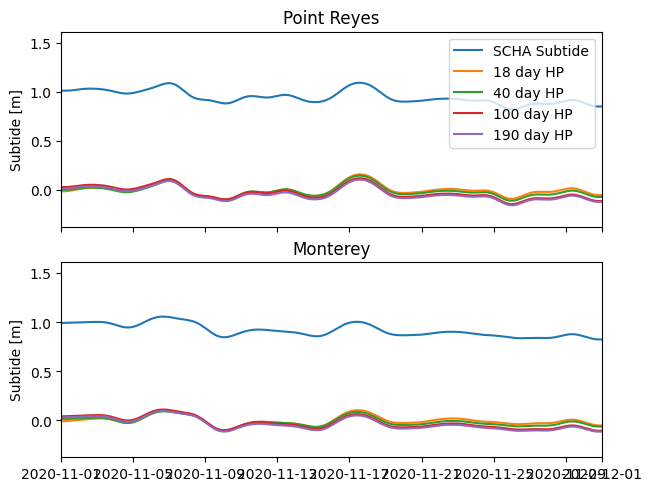

In [59]:
#zoom into a month
#plot the signals
fig, ax = plt.subplots(2,1,layout='constrained',sharex=True, sharey=True)

ax[0].plot(ptreyes.subtide,label='SCHA Subtide')
ax[0].plot(ptreyes['box_18d_filt'],label='18 day HP')
ax[0].plot(ptreyes['box_40d_filt'],label='40 day HP')
ax[0].plot(ptreyes['box_100d_filt'],label='100 day HP')
ax[0].plot(ptreyes['box_190d_filt'],label='190 day HP')

ax[1].plot(monterey.subtide,label='SCHA Subtide')
ax[1].plot(monterey['box_18d_filt'],label='18 day HP')
ax[1].plot(monterey['box_40d_filt'],label='40 day HP')
ax[1].plot(monterey['box_100d_filt'],label='100 day HP')
ax[1].plot(monterey['box_190d_filt'],label='190 day HP')

ax[0].set_ylabel('Subtide [m]')
ax[1].set_ylabel('Subtide [m]')
ax[0].set_title('Point Reyes')
ax[1].set_title('Monterey')
ax[0].legend()
ax[0].set_xlim(datetime(2020,11,1),datetime(2020,12,1))
plt.show()

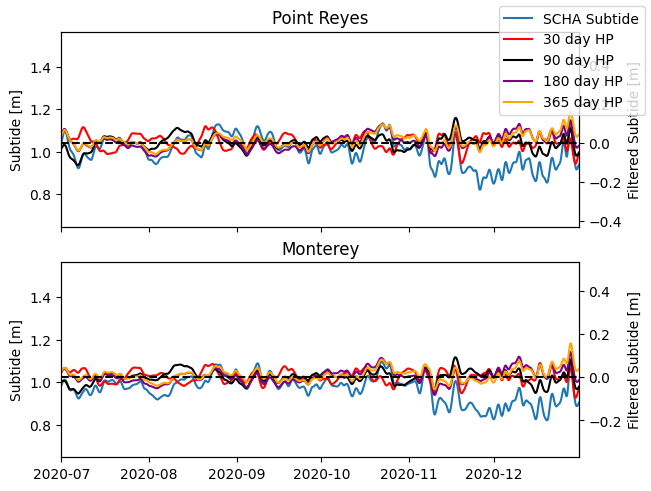

In [25]:
# #Zoom into a month
# #plot the signals
# fig, ax = plt.subplots(2,1,layout='constrained',sharex=True, sharey=True)

# ax[0].plot(ptreyes.subtide,label='SCHA Subtide')
# ax2=ax[0].twinx()
# ax2.plot(ptreyes['ellip_30d_filt'],label='30 day HP',color='r')
# ax2.plot(ptreyes['ellip_3m_filt'],label='90 day HP',color='k')
# ax2.plot(ptreyes['ellip_180d_filt'],label='180 day HP',color='purple')
# ax2.plot(ptreyes['ellip_365d_filt'],label='365 day HP',color='orange')


# ax2.axhline(y=0, color = 'k',linestyle='--')

# ax[1].plot(monterey.subtide)#,label='SCHA Subtide')
# ax3=ax[1].twinx()
# ax3.plot(monterey['ellip_30d_filt'],color='r')#,label='30 day HP')
# ax3.plot(monterey['ellip_3m_filt'],color='k')#,label='3 month HP')
# ax3.plot(monterey['ellip_180d_filt'],color='purple')
# ax3.plot(monterey['ellip_365d_filt'],color='orange')


# ax3.axhline(y=0, color = 'k',linestyle='--')

# ax[0].set_ylabel('Subtide [m]')
# ax2.set_ylabel('Filtered Subtide [m]')
# ax[1].set_ylabel('Subtide [m]')
# ax3.set_ylabel('Filtered Subtide [m]')
# ax[0].set_title('Point Reyes')
# ax[1].set_title('Monterey')
# fig.legend()
# ax[0].set_xlim(datetime(2020,7,1),datetime(2020,12,31))
# plt.show()


# Try plotting correlation between the jersey point salinity and the different residuals

In [26]:
jp_single

,datetime,jer_S[mS/cm],gap_length,gap
0,2009-08-29 15:15:00,1489.0,NaT,False
1,2009-08-29 15:30:00,1487.0,0 days 00:15:00,False
2,2009-08-29 15:45:00,1448.0,0 days 00:15:00,False
3,2009-08-29 16:00:00,1436.0,0 days 00:15:00,False
4,2009-08-29 16:15:00,1426.0,0 days 00:15:00,False
...,...,...,...,...
561915,2025-09-07 22:00:00,1275.0,0 days 00:15:00,False
561916,2025-09-07 22:15:00,1278.0,0 days 00:15:00,False
561917,2025-09-07 22:30:00,1277.0,0 days 00:15:00,False
561918,2025-09-07 22:45:00,1279.0,0 days 00:15:00,False


In [27]:
jp_single.set_index("datetime",inplace=True)
jp_single=jp_single.asfreq('15min')
jp_single_filt=filter_timeseries(jp_single.drop(columns=['gap_length','gap']))

In [28]:
jp_single.drop(columns=['gap_length','gap'])

,jer_S[mS/cm]
datetime,
2009-08-29 15:15:00,1489.0
2009-08-29 15:30:00,1487.0
2009-08-29 15:45:00,1448.0
2009-08-29 16:00:00,1436.0
2009-08-29 16:15:00,1426.0
...,...
2025-09-07 22:00:00,1275.0
2025-09-07 22:15:00,1278.0
2025-09-07 22:30:00,1277.0


In [29]:
jp_single_filt

,jer_S[mS/cm]
datetime,
2009-08-29 15:15:00,NaN
2009-08-29 15:30:00,NaN
2009-08-29 15:45:00,NaN
2009-08-29 16:00:00,NaN
2009-08-29 16:15:00,NaN
...,...
2025-09-07 22:00:00,NaN
2025-09-07 22:15:00,NaN
2025-09-07 22:30:00,NaN


In [30]:
#first make the sequences the same length
#df1['column_name'] = df2['column_name'].values
pr_salt=ptreyes
pr_salt['jp']=jp_single_filt['jer_S[mS/cm]']
pr_salt

,subtide,filled,ellip_3m_filt,ellip_30d_filt,ellip_180d_filt,ellip_365d_filt,box_18d_filt,box_40d_filt,box_100d_filt,box_190d_filt,jp
datetime,,,,,,,,,,,
2012-01-03 01:30:00,0.9306,0.9750,0.522591,0.521137,0.522953,0.523137,0.467041,0.458569,0.469994,0.479004,1143.574535
2012-01-03 02:00:00,0.9299,1.0670,0.520748,0.516369,0.521836,0.522386,0.465199,0.457276,0.469128,0.478216,1142.061779
2012-01-03 02:30:00,0.9292,1.1670,0.518902,0.511567,0.520718,0.521636,0.463358,0.455982,0.468262,0.477428,1140.505363
2012-01-03 03:00:00,0.9285,1.2700,0.517052,0.506731,0.519600,0.520886,0.461518,0.454689,0.467396,0.476640,1138.911518
2012-01-03 03:30:00,0.9279,1.3700,0.515256,0.501919,0.518537,0.520192,0.459778,0.453497,0.466630,0.475951,1137.286517
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-29 20:30:00,1.2244,0.2927,-0.046823,0.043929,0.044506,0.045716,0.633783,0.646553,0.665378,0.674372,1750.693749
2023-12-29 21:00:00,1.2226,0.4265,-0.047906,0.042070,0.043360,0.044629,0.633452,0.645255,0.663785,0.672688,1748.884943
2023-12-29 21:30:00,1.2207,0.5852,-0.049042,0.040166,0.042159,0.043486,0.633018,0.643858,0.662093,0.670904,1746.857004


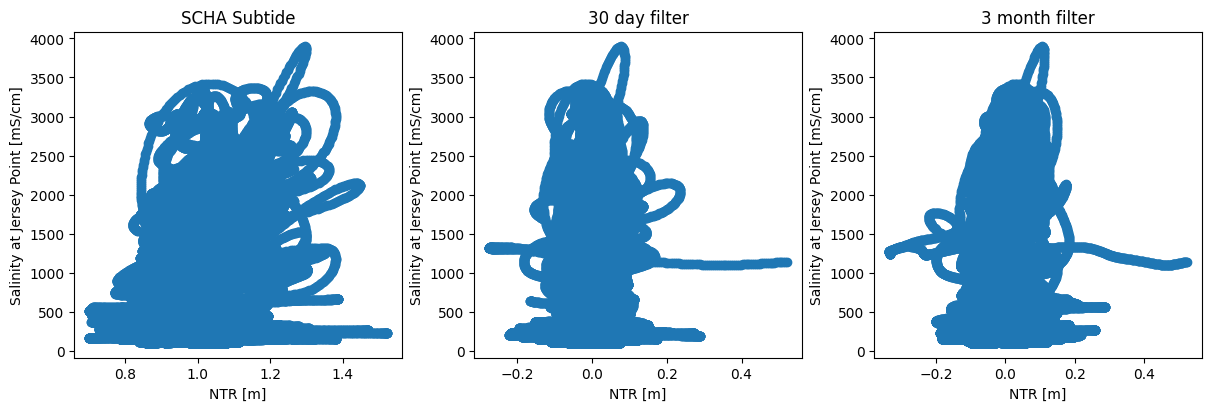

In [31]:
fig, ax = plt.subplots(1,3,layout='constrained',figsize=(12,4))
ax[0].scatter(pr_salt['subtide'],pr_salt['jp'])
ax[0].set_xlabel('NTR [m]')
ax[0].set_ylabel('Salinity at Jersey Point [mS/cm]')
ax[0].set_title('SCHA Subtide')

ax[1].scatter(pr_salt['ellip_30d_filt'],pr_salt['jp'])
ax[1].set_xlabel('NTR [m]')
ax[1].set_ylabel('Salinity at Jersey Point [mS/cm]')
ax[1].set_title('30 day filter')

ax[2].scatter(pr_salt['ellip_3m_filt'],pr_salt['jp'])
ax[2].set_xlabel('NTR [m]')
ax[2].set_ylabel('Salinity at Jersey Point [mS/cm]')
ax[2].set_title('3 month filter')
plt.show()

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


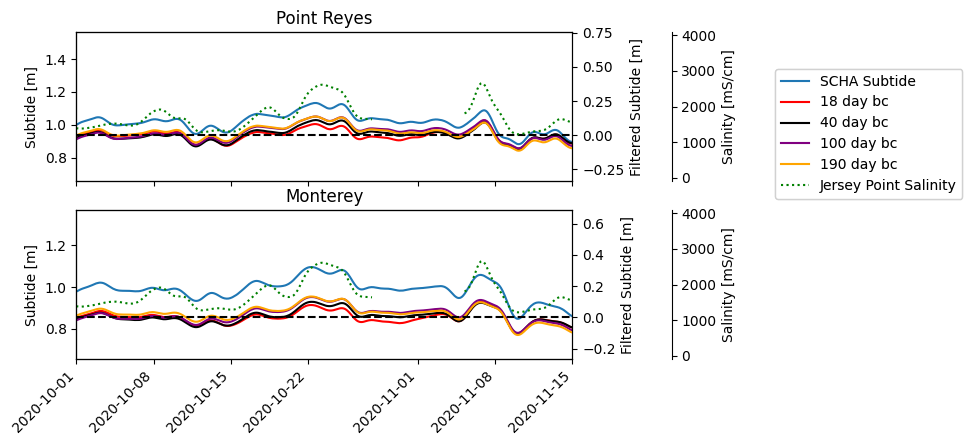

In [34]:
#Zoom into a month
#plot the signals
fig, ax = plt.subplots(2,1,layout='constrained',sharex=True)#, sharey=True)

unf, = ax[0].plot(ptreyes.subtide,label='SCHA Subtide')
ax2=ax[0].twinx()
f30, = ax2.plot(ptreyes['box_18d_filt'],label='18 day bc',color='r')
f90, = ax2.plot(ptreyes['box_40d_filt'],label='40 day bc',color='k')
f180, = ax2.plot(ptreyes['box_100d_filt'],label='100 day bc',color='purple')
f365, = ax2.plot(ptreyes['box_190d_filt'],label='190 day bc',color='orange')
ax2.axhline(y=0, color = 'k',linestyle='--')
ax4=ax[0].twinx()
jp, = ax4.plot(pr_salt['jp'],color='green',label='Jersey Point Salinity',linestyle=':')
ax4.spines.right.set_position(("axes", 1.2))
ax4.set_ylabel('Salinity [mS/cm]')

ax[1].plot(monterey.subtide)#,label='SCHA Subtide')
ax3=ax[1].twinx()
ax3.plot(monterey['box_18d_filt'],color='r')#,label='30 day HP')
ax3.plot(monterey['box_40d_filt'],color='k')#,label='3 month HP')
ax3.plot(monterey['box_100d_filt'],color='purple')
ax3.plot(monterey['box_190d_filt'],color='orange')
ax3.axhline(y=0, color = 'k',linestyle='--')
ax5=ax[1].twinx()
ax5.plot(pr_salt['jp'],color='green',linestyle=':')
ax5.spines.right.set_position(("axes", 1.2))
ax5.set_ylabel('Salinity [mS/cm]')

ax[0].set_ylabel('Subtide [m]')
ax2.set_ylabel('Filtered Subtide [m]')
ax[1].set_ylabel('Subtide [m]')
ax3.set_ylabel('Filtered Subtide [m]')
ax[0].set_title('Point Reyes')
ax[1].set_title('Monterey')
#fig.legend(loc='outside left upper')
leg = plt.legend(handles=[unf,f30,f90,f180,f365,jp],loc='upper right', bbox_to_anchor=(1.8, 2.0))
fig.add_artist(leg)
ax[0].set_xlim(datetime(2020,10,1),datetime(2020,11,15))
fig.autofmt_xdate(rotation=45)
plt.show()


In [ ]:
#Zoom into a month
#plot the signals
fig, ax = plt.subplots(2,1,layout='constrained',sharex=True)#, sharey=True)

ax[0].plot(ptreyes.subtide,label='SCHA Subtide')
ax2=ax[0].twinx()
f30, = ax2.plot(ptreyes['ellip_30d_filt'],label='30 day HP',color='r')
f90, = ax2.plot(ptreyes['ellip_3m_filt'],label='3 month HP',color='k')
f180, = ax2.plot(ptreyes['ellip_180d_filt'],label='180 day HP',color='purple')
f365, = ax2.plot(ptreyes['ellip_365d_filt'],label='365 day HP',color='orange')
ax2.axhline(y=0, color = 'k',linestyle='--')
ax4=ax[0].twinx()
jp, = ax4.plot(pr_salt['jp'],color='green',label='Jersey Point Salinity',linestyle=':')
ax4.spines.right.set_position(("axes", 1.2))
ax4.set_ylabel('Salinity [mS/cm]')

ax[1].plot(monterey.subtide)#,label='SCHA Subtide')
ax3=ax[1].twinx()
ax3.plot(monterey['ellip_30d_filt'],color='r')#,label='30 day HP')
ax3.plot(monterey['ellip_3m_filt'],color='k')#,label='3 month HP')
ax3.plot(monterey['ellip_180d_filt'],color='purple')
ax3.plot(monterey['ellip_365d_filt'],color='orange')
ax3.axhline(y=0, color = 'k',linestyle='--')
ax5=ax[1].twinx()
ax5.plot(pr_salt['jp'],color='green',linestyle=':')
ax5.spines.right.set_position(("axes", 1.2))
ax5.set_ylabel('Salinity [mS/cm]')

ax[0].set_ylabel('Subtide [m]')
ax2.set_ylabel('Filtered Subtide [m]')
ax[1].set_ylabel('Subtide [m]')
ax3.set_ylabel('Filtered Subtide [m]')
ax[0].set_title('Point Reyes')
ax[1].set_title('Monterey')
#fig.legend(loc='outside left upper')
leg = plt.legend(handles=[f30,f90,f180,f365,jp],loc='upper right', bbox_to_anchor=(1.8, 2.0))
fig.add_artist(leg)
ax[0].set_xlim(datetime(2020,10,1),datetime(2020,11,15))
fig.autofmt_xdate(rotation=45)
plt.show()


In [ ]:
#Zoom into a month
#Zoom into a month
#plot the signals
fig, ax = plt.subplots(2,1,layout='constrained',sharex=True)#, sharey=True)

ax[0].plot(ptreyes.subtide,label='SCHA Subtide')
ax2=ax[0].twinx()
f30, = ax2.plot(ptreyes['ellip_30d_filt'],label='30 day HP',color='r')
f90, = ax2.plot(ptreyes['ellip_3m_filt'],label='3 month HP',color='k')
f180, = ax2.plot(ptreyes['ellip_180d_filt'],label='180 day HP',color='purple')
f365, = ax2.plot(ptreyes['ellip_365d_filt'],label='365 day HP',color='orange')
ax2.axhline(y=0, color = 'k',linestyle='--')
ax4=ax[0].twinx()
jp, = ax4.plot(pr_salt['jp'],color='green',label='Jersey Point Salinity',linestyle=':')
ax4.spines.right.set_position(("axes", 1.2))
ax4.set_ylabel('Salinity [mS/cm]')

ax[1].plot(monterey.subtide)#,label='SCHA Subtide')
ax3=ax[1].twinx()
ax3.plot(monterey['ellip_30d_filt'],color='r')#,label='30 day HP')
ax3.plot(monterey['ellip_3m_filt'],color='k')#,label='3 month HP')
ax3.plot(monterey['ellip_180d_filt'],color='purple')
ax3.plot(monterey['ellip_365d_filt'],color='orange')
ax3.axhline(y=0, color = 'k',linestyle='--')
ax5=ax[1].twinx()
ax5.plot(pr_salt['jp'],color='green',linestyle=':')
ax5.spines.right.set_position(("axes", 1.2))
ax5.set_ylabel('Salinity [mS/cm]')

ax[0].set_ylabel('Subtide [m]')
ax2.set_ylabel('Filtered Subtide [m]')
ax[1].set_ylabel('Subtide [m]')
ax3.set_ylabel('Filtered Subtide [m]')
ax[0].set_title('Point Reyes')
ax[1].set_title('Monterey')
#fig.legend(loc='outside left upper')
leg = plt.legend(handles=[f30,f90,f180,f365,jp],loc='upper right', bbox_to_anchor=(1.8, 2.0))
fig.add_artist(leg)
ax[0].set_xlim(datetime(2015,11,1),datetime(2015,12,15))
fig.autofmt_xdate(rotation=45)
plt.show()


In [60]:
monterey

,subtide,filled,ellip_3m_filt,ellip_30d_filt,ellip_180d_filt,ellip_365d_filt,box_18d_filt,box_40d_filt,box_100d_filt,box_190d_filt
datetime,,,,,,,,,,
2012-01-03 01:30:00,0.8713,0.9420,0.489290,0.487929,0.489629,0.489801,NaN,NaN,NaN,NaN
2012-01-03 02:00:00,0.8715,1.0320,0.488045,0.483944,0.489064,0.489579,NaN,NaN,NaN,NaN
2012-01-03 02:30:00,0.8717,1.1300,0.486795,0.479923,0.488497,0.489358,NaN,NaN,NaN,NaN
2012-01-03 03:00:00,0.8720,1.2320,0.485598,0.475922,0.487986,0.489192,NaN,NaN,NaN,NaN
2012-01-03 03:30:00,0.8722,1.3310,0.484339,0.471830,0.487417,0.488969,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-12-29 20:30:00,1.1369,0.3367,-0.050550,0.054561,0.026294,0.024913,NaN,NaN,NaN,NaN
2023-12-29 21:00:00,1.1363,0.4742,-0.050890,0.053636,0.025861,0.024522,NaN,NaN,NaN,NaN
2023-12-29 21:30:00,1.1357,0.6271,-0.051228,0.052714,0.025428,0.024132,NaN,NaN,NaN,NaN


In [61]:
# Export the dataframe with filtered signals
ptreyes.to_csv("/global/scratch/users/jennaisrael/time_varying_data/tide_gauge_data/bcfiltered_SCHA_subtide_ptreyes.csv")
monterey.to_csv("/global/scratch/users/jennaisrael/time_varying_data/tide_gauge_data/bcfiltered_SCHA_subtide_monterey.csv")